### Imports

In [1]:
import importlib
from matplotlib.pyplot import figure
from AIBind.import_modules import *
from AIBind import AIBind

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/miniconda/lib/p

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
importlib.reload(AIBind)

<module 'AIBind.AIBind' from '/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py'>

### GPU Settings

In [3]:
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Tue Jul 13 23:28:07 2021       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   75C    P0    34W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |',
 '| N/A   76C    P0    33W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+---

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### VecNet Object

In [5]:
# Read In drugs and targets dataframes to pass to AIBind after changing column names 
with open('/data/sars-busters/Mol2Vec/chemicals_01_w_embed.pkl', 'rb') as file: 
    drugs = pkl.load(file)
    
with open('/data/sars-busters/Mol2Vec/amino_01_w_embed.pkl', 'rb') as file: 
    targets = pkl.load(file)

# Ensure correct column names    
drugs = drugs.rename(columns = {'Label' : 'InChiKey'})
targets = targets.rename(columns = {'Label' : 'target_aa_code'})

In [8]:
## Generated once and used across all models

targets_test = []
targets_validation = []
edges_test = []
edges_validation = []
train_sets = []

for run_number in tqdm(range(5)):
    
    targets_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_' + str(run_number) + '.csv'))
    edges_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_' + str(run_number) + '.csv'))    
    targets_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_' + str(run_number) + '.csv'))    
    edges_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_' + str(run_number) + '.csv'))    
    train_sets.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_' + str(run_number) + '.csv'))    

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
# Create object
vecnet_object = AIBind.AIBind(interactions_location = '/data/sars-busters-consolidated/GitData/interactions/Network_Derived_Negatives.csv',
                              interactions = None,
                              interaction_y_name = 'Y',

                              absolute_negatives_location = '/data/sars-busters-consolidated/master_files/absolute_negatives_bindingDB.csv',
                              absolute_negatives = None,

                              drugs_location = None,
                              drugs_dataframe = drugs,
                              drug_inchi_name = 'InChiKey',
                              drug_smile_name = 'SMILE',

                              targets_location = None,
                              targets_dataframe = targets, 
                              target_seq_name = 'target_aa_code',

                              mol2vec_location = '/data/sars-busters/Mol2Vec/model_300dim.pkl',
                              mol2vec_model = None,

                              protvec_location = '/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams.csv', 
                              protvec_model = None,

                              nodes_test = targets_test, 
                              nodes_validation = targets_validation, 

                              edges_test = edges_test, 
                              edges_validation = edges_validation,  

                              model_out_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes',

                              debug = False)

### Create 7-hop Training Data (Optional)

#### Functions for Degree Stratification 

In [5]:
def get_degree_stratification(all_samples, ratio = [0.01, 0.99], return_item = 'list', on = 'drug'):
    
    
    column_name = {'drug': 'InChiKey',
                  'target': 'target_aa_code'}
        
        
    positive_samples = all_samples[all_samples['Y'] == 1]
    negative_samples = all_samples[all_samples['Y'] == 0]

    
    pos_degree = positive_samples.groupby(column_name[on]).count()['Y'].to_frame().rename(columns = {'Y': 'degree'})
    neg_degree = negative_samples.groupby(column_name[on]).count()['Y'].to_frame().rename(columns = {'Y': 'degree'})
    
    degree_df = pd.merge(pos_degree, neg_degree, left_on = column_name[on], right_on = column_name[on], suffixes = ['_pos', '_neg'])
    
    del pos_degree
    del neg_degree
    
    degree_df['total_degree'] = degree_df['degree_pos'] + degree_df['degree_neg']    
    degree_df['degree_fraction'] = degree_df['degree_pos'] / degree_df['total_degree'] 
        
    if return_item == 'list':
        return set(degree_df[(degree_df['degree_fraction'] > ratio[0]) & (degree_df['degree_fraction'] < ratio[1])].index.tolist())

    elif return_item == 'df':
        return degree_df[(degree_df['degree_fraction'] > ratio[0]) & (degree_df['degree_fraction'] < ratio[1])]
    
    
    elif return_item == 'full_df':
        return degree_df
    
    else:
        print('Incorrect return_item Specified')

def get_unique_counts(df):
    
    
    neg_sample_targets = set(df[df['Y'] == 0]['target_aa_code'].tolist())
    pos_sample_targets = set(df[df['Y'] == 1]['target_aa_code'].tolist())


    print('Distinct TARGETS in positive samples: ', len(pos_sample_targets))
    print('Distinct TARGETS in negative samples: ', len(neg_sample_targets))
    
    neg_sample_drugs = set(df[df['Y'] == 0]['InChiKey'].tolist())
    pos_sample_drugs = set(df[df['Y'] == 1]['InChiKey'].tolist())


    print('Distinct DRUGS in positive samples: ', len(pos_sample_drugs))
    print('Distinct DRUGS in negative samples: ', len(neg_sample_drugs))
    
    return len(pos_sample_targets),len(neg_sample_targets),len(pos_sample_drugs),len(neg_sample_drugs)

#### Creating 7-hop negative samples for training

  0%|          | 0/30813 [00:00<?, ?it/s]

  0%|          | 0/8111 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


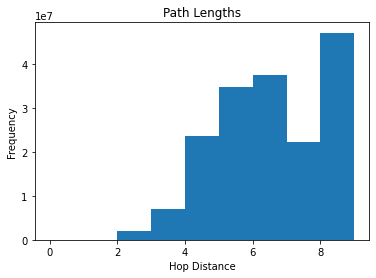

0it [00:00, ?it/s]

In [10]:
interactions = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_1.csv')

hop_7_negatives = vecnet_object.create_n_hop_negatives(interactions = interactions,
                                     path_lower_bound = 7,
                                     path_upper_bound = 8,
                                     max_hop = 9,
                                     show_plot = True,
                                     return_negatives = True)

In [16]:
all_samples = pd.concat([interactions,hop_7_negatives])

In [17]:
all_samples['Y'].value_counts()

0    11086946
1       30813
Name: Y, dtype: int64

In [18]:
get_unique_counts(all_samples)

Distinct TARGETS in positive samples:  5104
Distinct TARGETS in negative samples:  4611
Distinct DRUGS in positive samples:  8111
Distinct DRUGS in negative samples:  7468


(5104, 4611, 8111, 7468)

In [19]:
## Randomly selecting 7-hop negatives to create class balance

selected_interactions_subset = pd.concat([all_samples[all_samples['Y']==1], all_samples[all_samples['Y']==0].sample(frac = len(all_samples[all_samples['Y']==1])/len(all_samples))]) 

In [20]:
selected_interactions_subset

Target   Source        Type  Y                     InChiKey  \
0          6093.0  11246.0  Undirected  1  DEJXHCDDTLTVNB-FRVJLOGJSA-N   
1         10888.0   3006.0  Undirected  1  IAVHKMVGTPXJIC-UHFFFAOYSA-N   
2          5855.0  11533.0  Undirected  1  KFQYTPMOWPVWEJ-INIZCTEOSA-N   
3          4812.0    431.0  Undirected  1  GXJABQQUPOEUTA-OLKMYRHANA-N   
4          9288.0   2799.0  Undirected  1  VJYDOJXJUCJUHL-UHFFFAOYSA-N   
...           ...      ...         ... ..                          ...   
8189726       NaN      NaN         NaN  0  VABIMMIJVWNHFI-UHFFFAOYSA-N   
11084416      NaN      NaN         NaN  0  SZHRIPFGZWWRKW-VIFPVBQESA-N   
4124153       NaN      NaN         NaN  0  YCDHZDINQZLSRR-DNQXCXABSA-N   
6578557       NaN      NaN         NaN  0  BWTHJLODYBOEIY-VHEBQXMUSA-N   
10800153      NaN      NaN         NaN  0  VYNKVNDKAOGAAQ-RUZDIDTESA-N   

                                             target_aa_code  
0         MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...  
1         MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...  
2         MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...  
3         MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...  
4         MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...  
...                                                     ...  
8189726   MSNQYGDKNLKIFSLNSNPELAKEIADIVGVQLGKCSVTRFSDGEV...  
11084416  MTTFGAVAEWRLPSLRRATLWIPQWFAKKAIFNSPLEAAMAFPHLQ...  
4124153   MSTPSIVIASARTAVGSFNGAFANTPAHELGATVISAVLERAGVAA...  
6578557   MGQGDESERIVINVGGTRHQTYRSTLRTLPGTRLAWLAEPDAHSHF...  
10800153  MRGLSRRVQAMKPSATVAVNAKALELRRQGVDLVALTAGEPDFDTP...  

[61541 rows x 6 columns]

In [21]:
get_unique_counts(selected_interactions_subset)

Distinct TARGETS in positive samples:  5104
Distinct TARGETS in negative samples:  4472
Distinct DRUGS in positive samples:  8111
Distinct DRUGS in negative samples:  6810


(5104, 4472, 8111, 6810)

In [22]:
balanced_target_subset = get_degree_stratification(selected_interactions_subset, ratio = [0.0001,0.9999], return_item = 'df', on = 'target')
len(balanced_target_subset)

4472

In [23]:
balanced_drug_subset = get_degree_stratification(selected_interactions_subset, ratio = [0.0001,0.9999], return_item = 'df', on = 'drug')
len(balanced_drug_subset)

6810

In [24]:
subsample_bal_both_filtered_samples = selected_interactions_subset[(selected_interactions_subset['target_aa_code'].isin(balanced_target_subset.index)) & 
                                       (selected_interactions_subset['InChiKey'].isin(balanced_drug_subset.index))]

get_unique_counts(subsample_bal_both_filtered_samples)

Distinct TARGETS in positive samples:  3970
Distinct TARGETS in negative samples:  4472
Distinct DRUGS in positive samples:  6480
Distinct DRUGS in negative samples:  6810


(3970, 4472, 6480, 6810)

In [25]:
subsample_bal_both_filtered_samples.to_csv('/data/sars-busters-consolidated/GitData/interactions/Network_Derived_Negatives.csv')

### Training and Testing VecNet

#### Create 11+ Hop Negatives for Validation and Test

In [10]:
test_creation_interactions = pd.read_csv('/data/sars-busters-consolidated/interactions/dataset_1.csv')

  0%|          | 0/30813 [00:00<?, ?it/s]

  0%|          | 0/8111 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


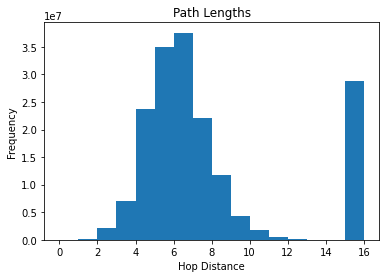

0it [00:00, ?it/s]

In [6]:
vecnet_object.create_n_hop_negatives(interactions = test_creation_interactions,
                                     path_lower_bound = 11,
                                     path_upper_bound = 15,
                                     max_hop = 16,
                                     show_plot = True,
                                     return_negatives = False)

#### Create K Fold Test Validation Split 

In [7]:
vecnet_object.create_test_splits(interactions = test_creation_interactions,
                                 frac = 0.15,
                                 num_splits = 5,
                                 seed = 2021,
                                 update_dataframes = True,
                                 return_dataframes = False,
                                 debug = True)

Number Of Unseen Targets In Each Set :  [1020, 1020, 1020, 1020, 1024]
Number Of Seen Targets In Each Set :  [4084, 4084, 4084, 4084, 4080]
Length Of Unseen Target DataFrames (Positives Only) :  [6193, 6790, 5578, 6079, 6173]
Length Of Unseen Targets DataFrames (Complete) :  [12983, 13580, 12368, 12869, 12963]
Length Of Unseen Edges DataFrames (Complete) :  [7386, 7206, 7570, 7420, 7392]


  0%|          | 0/5 [00:00<?, ?it/s]

Unseen Nodes/Targets 
Shapes Of Validation Sets :  [6492, 6790, 6184, 6435, 6482]
Shapes Of Test Sets :  [6491, 6790, 6184, 6434, 6481]


  0%|          | 0/5 [00:00<?, ?it/s]

Unseen Edges
Shapes Of Validation Sets :  [3693, 3603, 3785, 3710, 3696]
Shapes Of Test Sets :  [3693, 3603, 3785, 3710, 3696]


#### Generate Mol2Vec and ProtVec Embeddings

In [8]:
vecnet_object.get_mol2vec_embeddings()
vecnet_object.get_protvec_embeddings()

vecnet_object.create_train_sets(unseen_nodes_flag = False, ## Unseen nodes for True, unseen targets for False
                                data_leak_check = True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Set :  0
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (38125, 3)
Nodes Test :  (6491, 9)
Nodes Val :  (6492, 3)
Edge Test :  (3693, 3)
Edge Val :  (3693, 3)
Positive / Negatative Ratio :  0.5453366300514774

Set :  1
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (37340, 3)
Nodes Test :  (6935, 9)
Nodes Val :  (6790, 3)
Edge Test :  (3603, 3)
Edge Val :  (3603, 3)
Positive / Negatative Ratio :  0.5286363450280427

Set :  2
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (37119, 3)
Nodes Test :  (6329, 9)
Nodes Val :  (6184, 3)
Edge Test :  (3785, 3)
Edge Val :  (3785, 3)
Positive / Negatative Ratio :  0.51797325481536

Set :  3
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set

#### Train Model

In [17]:
vecnet_object.train_vecnet(model_name = 'vecnet_ds2_5_fold_unseen_targets',
                           epochs = 20,
                           version = 0,
                           learning_rate = 0.00001,
                           beta_1 = 0.9,
                           beta_2 = 0.999,
                           batch_size = 16,
                           chunk_test_frequency = 250)

There already exists saved model data in this directory. Please select a new directory for this training or train as part of a new AIBind object.
New directory : /data/sars-busters-consolidated/GitData/tar-101


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.51
Unseen Edges AUC : 0.47
Unseen Nodes AUP : 0.52
Unseen Edges AUP : 0.52

Unseen Nodes AUC : 0.59
Unseen Edges AUC : 0.63
Unseen Nodes AUP : 0.58
Unseen Edges AUP : 0.65

Unseen Nodes AUC : 0.68
Unseen Edges AUC : 0.72
Unseen Nodes AUP : 0.68
Unseen Edges AUP : 0.75

Unseen Nodes AUC : 0.69
Unseen Edges AUC : 0.75
Unseen Nodes AUP : 0.7
Unseen Edges AUP : 0.78

Unseen Nodes AUC : 0.71
Unseen Edges AUC : 0.77
Unseen Nodes AUP : 0.72
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.72
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.72
Unseen Edges AUP : 0.81

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.79
Unseen Nodes AUP : 0.73
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.73
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.73
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.74
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.74
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.74
Unseen Edge

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.47
Unseen Edges AUC : 0.49
Unseen Nodes AUP : 0.51
Unseen Edges AUP : 0.54

Unseen Nodes AUC : 0.64
Unseen Edges AUC : 0.63
Unseen Nodes AUP : 0.66
Unseen Edges AUP : 0.64

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.72
Unseen Nodes AUP : 0.76
Unseen Edges AUP : 0.73

Unseen Nodes AUC : 0.76
Unseen Edges AUC : 0.75
Unseen Nodes AUP : 0.79
Unseen Edges AUP : 0.77

Unseen Nodes AUC : 0.78
Unseen Edges AUC : 0.76
Unseen Nodes AUP : 0.8
Unseen Edges AUP : 0.78

Unseen Nodes AUC : 0.79
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.82
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.82
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.79
Unseen Nodes AUP : 0.83
Unseen Edges AUP : 0.81

Unseen Nodes AUC : 0.81
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.83
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.81
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.83
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.81
Unseen Edges 

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.41
Unseen Edges AUC : 0.42
Unseen Nodes AUP : 0.42
Unseen Edges AUP : 0.48

Unseen Nodes AUC : 0.64
Unseen Edges AUC : 0.64
Unseen Nodes AUP : 0.58
Unseen Edges AUP : 0.63

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.73
Unseen Nodes AUP : 0.69
Unseen Edges AUP : 0.73

Unseen Nodes AUC : 0.76
Unseen Edges AUC : 0.77
Unseen Nodes AUP : 0.74
Unseen Edges AUP : 0.78

Unseen Nodes AUC : 0.78
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.77
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.79
Unseen Edges AUC : 0.79
Unseen Nodes AUP : 0.77
Unseen Edges AUP : 0.81

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.78
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.81
Unseen Nodes AUP : 0.79
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.81
Unseen Nodes AUP : 0.79
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.8
Unseen Edges AUC : 0.82
Unseen Nodes AUP : 0.79
Unseen Edges AUP : 0.84

Unseen Nodes AUC : 0.8
Unseen Edges 

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.41
Unseen Edges AUC : 0.47
Unseen Nodes AUP : 0.45
Unseen Edges AUP : 0.52

Unseen Nodes AUC : 0.64
Unseen Edges AUC : 0.62
Unseen Nodes AUP : 0.58
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.69
Unseen Edges AUC : 0.71
Unseen Nodes AUP : 0.62
Unseen Edges AUP : 0.72

Unseen Nodes AUC : 0.71
Unseen Edges AUC : 0.75
Unseen Nodes AUP : 0.66
Unseen Edges AUP : 0.77

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.77
Unseen Nodes AUP : 0.68
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.74
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.7
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.74
Unseen Edges AUC : 0.79
Unseen Nodes AUP : 0.71
Unseen Edges AUP : 0.81

Unseen Nodes AUC : 0.75
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.71
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.75
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.72
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.76
Unseen Edges AUC : 0.81
Unseen Nodes AUP : 0.73
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.76
Unseen Edge

  0%|          | 0/20 [00:00<?, ?it/s]

Unseen Nodes AUC : 0.36
Unseen Edges AUC : 0.38
Unseen Nodes AUP : 0.41
Unseen Edges AUP : 0.45

Unseen Nodes AUC : 0.63
Unseen Edges AUC : 0.62
Unseen Nodes AUP : 0.61
Unseen Edges AUP : 0.62

Unseen Nodes AUC : 0.69
Unseen Edges AUC : 0.69
Unseen Nodes AUP : 0.67
Unseen Edges AUP : 0.67

Unseen Nodes AUC : 0.73
Unseen Edges AUC : 0.73
Unseen Nodes AUP : 0.72
Unseen Edges AUP : 0.73

Unseen Nodes AUC : 0.75
Unseen Edges AUC : 0.76
Unseen Nodes AUP : 0.74
Unseen Edges AUP : 0.76

Unseen Nodes AUC : 0.76
Unseen Edges AUC : 0.78
Unseen Nodes AUP : 0.76
Unseen Edges AUP : 0.79

Unseen Nodes AUC : 0.77
Unseen Edges AUC : 0.79
Unseen Nodes AUP : 0.77
Unseen Edges AUP : 0.8

Unseen Nodes AUC : 0.78
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.78
Unseen Edges AUP : 0.81

Unseen Nodes AUC : 0.78
Unseen Edges AUC : 0.8
Unseen Nodes AUP : 0.78
Unseen Edges AUP : 0.82

Unseen Nodes AUC : 0.78
Unseen Edges AUC : 0.81
Unseen Nodes AUP : 0.78
Unseen Edges AUP : 0.83

Unseen Nodes AUC : 0.79
Unseen Ed

#### Get Validation Results

In [18]:
vecnet_object.get_validation_results(model_name = None, 
                                    version_number = None,
                                    show_plots = True,
                                    plot_title = 'Validation Results - 5 Fold Cross Validation',
                                    num_cols = 2,
                                    plot_height = 1500,
                                    plot_width = 1500,
                                    write_plot_to_html = True,
                                    plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets',
                                    plot_name = 'Validation')

(Epoch * Chunk) With Highest Unseen Node and Edge Score :  14
(Epoch * Chunk) With Highest Unseen Node Score :  14
(Epoch * Chunk) With Highest Unseen Edge Score :  14
Validation Performance
Best Model Suffix :  _epoch_14_idx_0.model
Unseen Node AUC :  0.7857795690325492 +/- 0.022171383895598872
Unseen Node AUP :  0.7755223400752119 +/- 0.03732499737894704
Unseen Edges AUC :  0.8185920149144191 +/- 0.005430679675099097
Unseen Edges AUP :  0.8354410637270435 +/- 0.006053246179577123


#### Get Test Results

Testing on model :  vecnet_ds2_5_fold_unseen_targets_v00_run0_07-13_23h41_epoch_14_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_targets_v00_run1_07-13_23h49_epoch_14_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_targets_v00_run2_07-13_23h57_epoch_14_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_targets_v00_run3_07-14_00h05_epoch_14_idx_0.model
Testing on model :  vecnet_ds2_5_fold_unseen_targets_v00_run4_07-14_00h13_epoch_14_idx_0.model


Unseen Nodes / Targets     Unseen Edges
AUC                 0.779 +/- 0.025  0.811 +/- 0.008
AUP                 0.752 +/- 0.039   0.825 +/- 0.01
F1 Score            0.712 +/- 0.011   0.744 +/- 0.01
F1 Threshold         0.18 +/- 0.059  0.188 +/- 0.034

Confusion Matrix - Unseen Nodes / Targets : 


Pred (0)       Pred (1)
True (0)  0.77 +/- 0.02  0.35 +/- 0.05
True (1)  0.23 +/- 0.02  0.65 +/- 0.05

Confusion Matrix - Unseen Edges : 


Pred (0)      Pred (1)
True (0)  0.76 +/- 0.01  0.3 +/- 0.01
True (1)  0.24 +/- 0.01  0.7 +/- 0.01

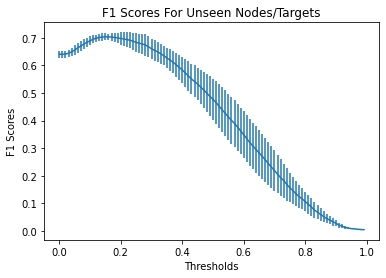

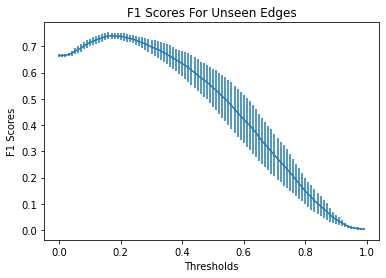

<Figure size 432x288 with 0 Axes>

In [19]:
vecnet_object.get_test_results(model_name = None, 
                            version_number = None, 
                            optimal_validation_model = None, 
                            drug_filter_list = [], 
                            target_filter_list = targets['target_aa_code'].tolist(), 
                            write_plot_to_disk = True, 
                            plot_dir = '/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets', 
                            plot_name = 'Test')

#### Stats on Test Results

In [20]:
test_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = vecnet_object.nodes_test,
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = False,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = targets['target_aa_code'].tolist(),
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_0/vecnet_ds2_5_fold_unseen_targets_v00_run0_07-13_23h41_epoch_14_idx_0.model
filtered_nodes_test :  (6491, 3)
Drugs :  3132
Targets :  907
pred_targets_dataframe :  (907, 2)
pred_drugs_dataframe :  (3124, 2)
X0, X1 :  (6491, 100) (6491, 300)
filtered_nodes_test :  (6900, 3)
Drugs :  3366
Targets :  947
pred_targets_dataframe :  (947, 2)
pred_drugs_dataframe :  (3340, 2)
X0, X1 :  (6900, 100) (6900, 300)
filtered_nodes_test :  (6293, 3)
Drugs :  2660
Targets :  988
pred_targets_dataframe :  (988, 2)
pred_drugs_dataframe :  (2631, 2)
X0, X1 :  (6293, 100) (6293, 300)
filtered_nodes_test :  (6539, 3)
Drugs :  3466
Targets :  956
pred_targets_dataframe :  (956, 2)
pred_drugs_dataframe :  (3431, 2)
X0, X1 :  (6539, 100) (6539, 300)
filtered_nodes_test :  (6594, 3)
Drugs :  2581
Targets :  997
pred_targets_dataframe :  (997, 2)
pred_drugs_dataframe :  (2545, 2)
X0, X1 :  (6594, 100) (6594, 300)
Testing on model :  /data/

/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py:1207: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
all_test = pd.concat([test_preidcitons_5fold_average[0],test_preidcitons_5fold_average[1],test_preidcitons_5fold_average[2],test_preidcitons_5fold_average[3],test_preidcitons_5fold_average[4]])

In [22]:
all_test['binary_Y'] = [1 if x > 0.25 else 0 for x in all_test['Averaged Predictions'].tolist()]

In [23]:
all_test_fp = all_test[(all_test.Y == 0) & (all_test.binary_Y == 1)]
all_test_tp = all_test[(all_test.Y == 1) & (all_test.binary_Y == 1)]
all_test_fn = all_test[(all_test.Y == 1) & (all_test.binary_Y == 0)]
all_test_tn = all_test[(all_test.Y == 0) & (all_test.binary_Y == 0)]

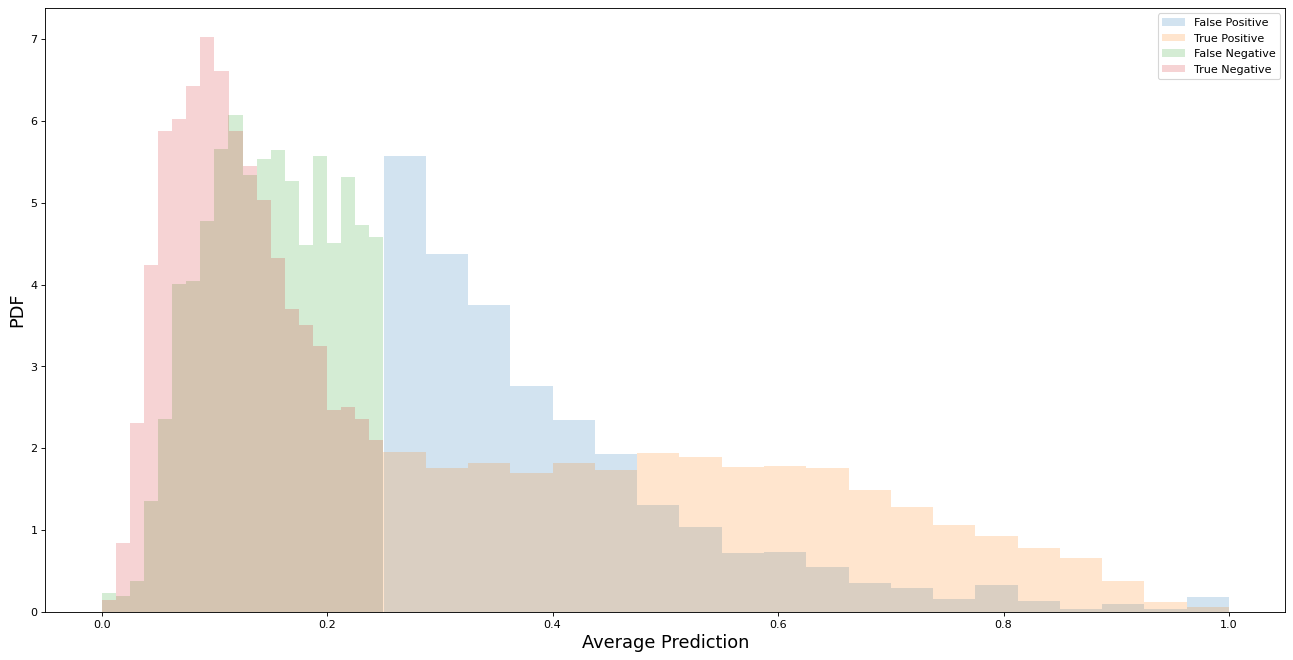

In [24]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(all_test_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.hist(all_test_fn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Negative')
plt.hist(all_test_tn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Negative')
plt.legend()
plt.xlabel('Average Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)
plt.show()

Text(0, 0.5, 'PDF')

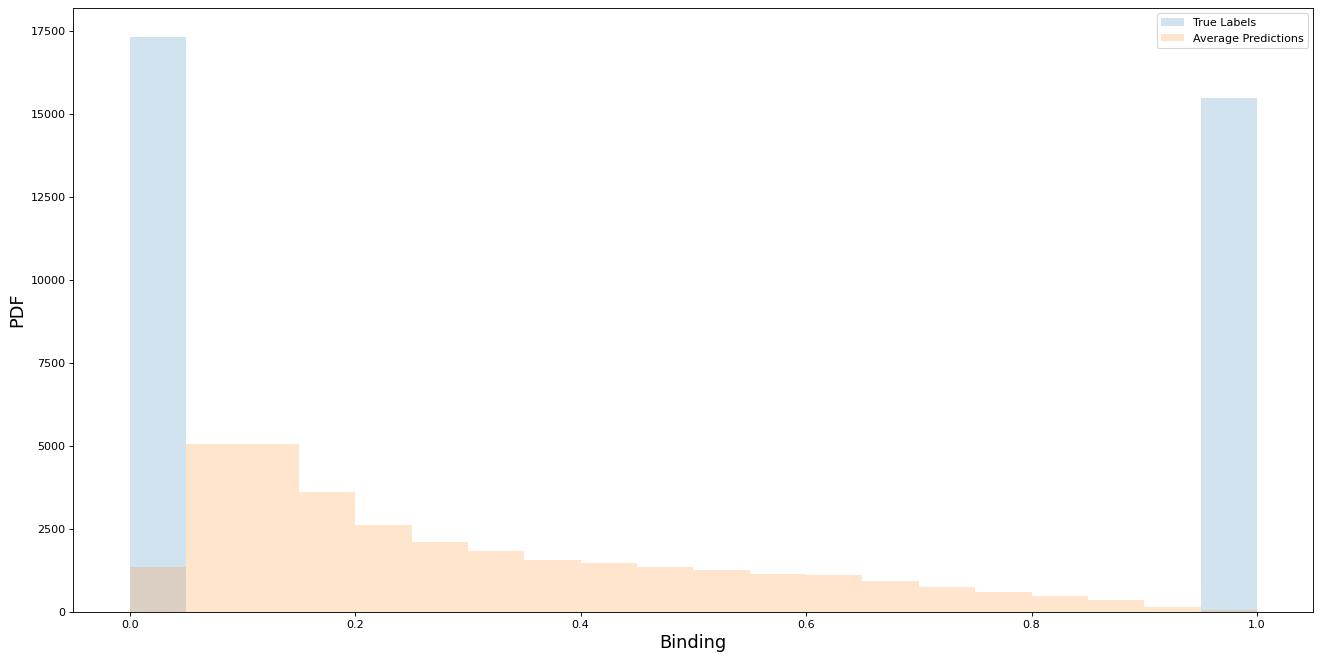

In [25]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test['Y'],density=False,alpha=0.2,bins=20,label='True Labels')
plt.hist(all_test['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Average Predictions')
plt.legend()
plt.xlabel('Binding',fontsize=16)
plt.ylabel('PDF',fontsize=16)

Text(0, 0.5, 'PDF')

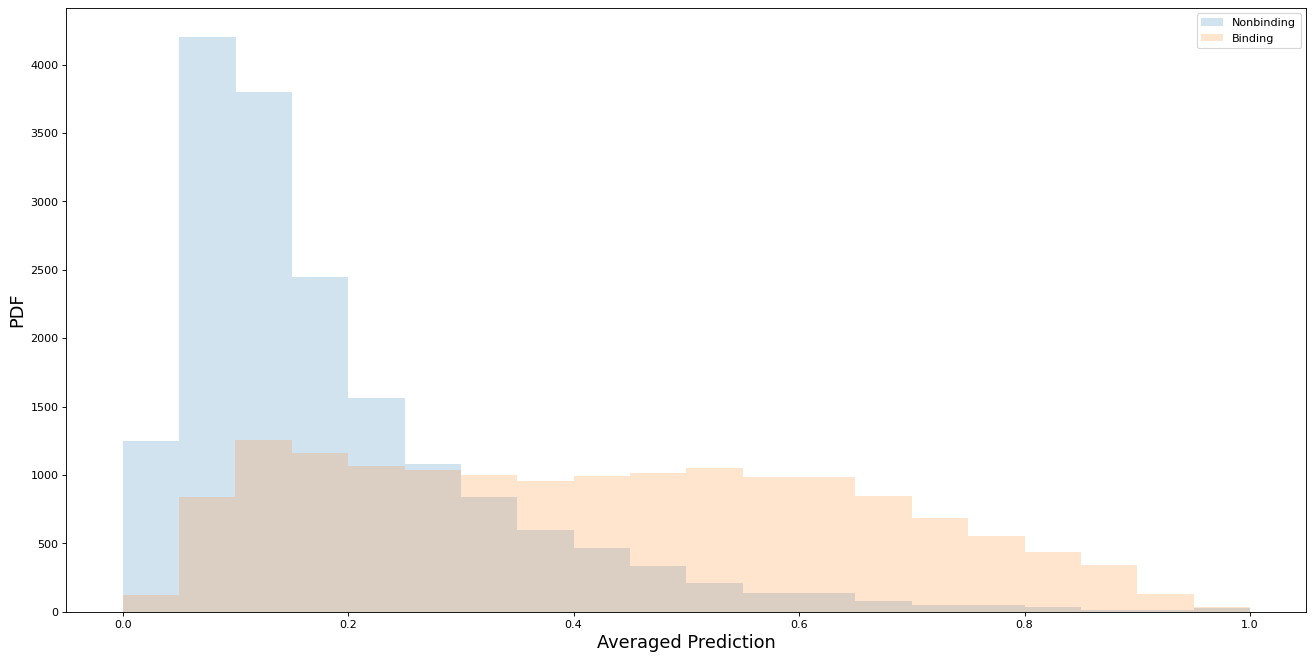

In [26]:
figure(figsize=(20, 10), dpi=80)
plt.hist(all_test[all_test['Y']==0]['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Nonbinding')
plt.hist(all_test[all_test['Y']==1]['Averaged Predictions'],density=False,alpha=0.2,bins=20,label='Binding')
plt.legend()
plt.xlabel('Averaged Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)

#### Saving the VecNet object

In [27]:
pkl.dump(vecnet_object, file = open("/data/sars-busters-consolidated/GitData/VecNet_unseen_targets.pickle", "wb"))

In [54]:
vecnet_object.train_sets[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_0.csv')
vecnet_object.train_sets[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_1.csv')
vecnet_object.train_sets[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_2.csv')
vecnet_object.train_sets[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_3.csv')
vecnet_object.train_sets[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_4.csv')

vecnet_object.nodes_test[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_0.csv')
vecnet_object.nodes_test[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_1.csv')
vecnet_object.nodes_test[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_2.csv')
vecnet_object.nodes_test[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_3.csv')
vecnet_object.nodes_test[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_4.csv')

vecnet_object.edges_test[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_0.csv')
vecnet_object.edges_test[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_1.csv')
vecnet_object.edges_test[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_2.csv')
vecnet_object.edges_test[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_3.csv')
vecnet_object.edges_test[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_4.csv')

In [55]:
vecnet_object.nodes_validation[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_0.csv')
vecnet_object.nodes_validation[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_1.csv')
vecnet_object.nodes_validation[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_2.csv')
vecnet_object.nodes_validation[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_3.csv')
vecnet_object.nodes_validation[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_4.csv')

vecnet_object.edges_validation[0].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_0.csv')
vecnet_object.edges_validation[1].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_1.csv')
vecnet_object.edges_validation[2].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_2.csv')
vecnet_object.edges_validation[3].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_3.csv')
vecnet_object.edges_validation[4].to_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_4.csv')

#### Predictions for SARS-CoV-2 genes


In [28]:
sars_targets = pd.read_csv('/data/External Predictions/SARS Sequences/20201203_Targets_Sequences_SARS_Cov2.csv')

In [29]:
unique_ligands = set(test_creation_interactions['InChiKey'].tolist())

InChiKey_list = []
target_aa_code_list = []
ID_list = []
gene_list = []

for lig in tqdm(unique_ligands):
    for index, row in sars_targets.iterrows():
        InChiKey_list.append(lig)
        target_aa_code_list.append(row['Sequence'])
        ID_list.append(row['ID'])
        gene_list.append(row['gene'])
        
sars_preidcitons = pd.DataFrame()

sars_preidcitons['InChiKey'] = InChiKey_list
sars_preidcitons['target_aa_code'] = target_aa_code_list
sars_preidcitons['ID'] = ID_list
sars_preidcitons['gene'] = gene_list

  0%|          | 0/8111 [00:00<?, ?it/s]

In [30]:
sars_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [sars_preidcitons],
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_0/vecnet_ds2_5_fold_unseen_targets_v00_run0_07-13_23h41_epoch_14_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_1/vecnet_ds2_5_fold_unseen_targets_v00_run1_07-13_23h49_epoch_14_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_2/vecnet_ds2_5_fold_unseen_targets_v00_run2_07-13_23h57_epoch_14_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_3/vecnet_ds2_5_fold_unseen_targets_v00_run3_07-14_00h05_epoch_14_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_4/vecnet_ds2_5_fold_unseen_targets_v00_run4_07-14_00h13_epoch_14_idx_0.model
filtered_nodes_test :  (267663, 4)
Drugs :  8111
Targets :  33


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (267663, 100) (267663, 300)
unseen_targets_pred :  (267663,)
list :  267663


In [31]:
print('Expected number of ligands: ',len(set(sars_preidcitons['InChiKey'].tolist())))
print('Ligands present in prediction: ',len(set(sars_preidcitons_5fold_average[0]['InChiKey'].tolist())))

Expected number of ligands:  8111
Ligands present in prediction:  8111


In [32]:
print('Expected number of pairs: ',len(sars_preidcitons))
print('Pairs present in prediction: ',len(sars_preidcitons_5fold_average[0]))

Expected number of pairs:  267663
Pairs present in prediction:  267663


Text(0.5, 1.0, 'VecNet Predictions for SARS-CoV-2 genes')

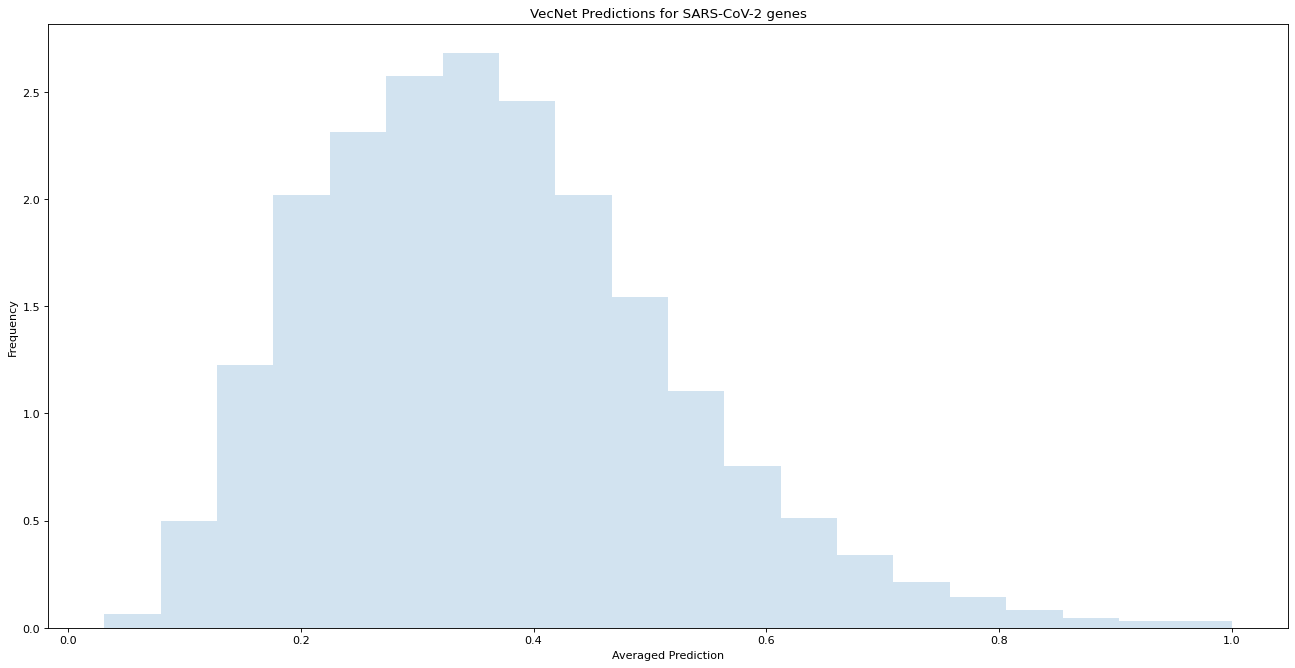

In [33]:
figure(figsize=(20, 10), dpi=80)
plt.hist(sars_preidcitons_5fold_average[0]['Averaged Predictions'].tolist(),density=True,alpha=0.2,bins=20)
plt.xlabel('Averaged Prediction')
plt.ylabel('Frequency')
plt.title('VecNet Predictions for SARS-CoV-2 genes')

In [34]:
sars_preidcitons_5fold_average[0].to_csv('/data/sars-busters-consolidated/GitData/sars_prdicitons_unseen_targets.csv')

#### Predictions for Human Genes

In [35]:
human_targets = pd.read_csv('../../covid-target-finder/data/intermediate/330_corona_genes_preprocessed.csv')

In [36]:
human_targets = human_targets[['hgnc_symbol','amino_acid_sequence']]

In [37]:
processed_amino_acid_sequence = []

for index, row in tqdm(human_targets.iterrows()):
    if '*' in row['amino_acid_sequence']:
        aa_seq_chinks = row['amino_acid_sequence'].split('*')
        processed_amino_acid_sequence.append(max(aa_seq_chinks, key=len))
    else:
        processed_amino_acid_sequence.append(row['amino_acid_sequence'])
        
human_targets['target_aa_code'] = processed_amino_acid_sequence

0it [00:00, ?it/s]

In [38]:
unique_ligands = set(test_creation_interactions['InChiKey'].tolist())

InChiKey_list = []
target_aa_code_list = []
ID_list = []
gene_list = []

for lig in tqdm(unique_ligands):
    for index, row in human_targets.iterrows():
        InChiKey_list.append(lig)
        target_aa_code_list.append(row['target_aa_code'])
        ID_list.append(row['hgnc_symbol'])
        
human_predicitons = pd.DataFrame()

human_predicitons['InChiKey'] = InChiKey_list
human_predicitons['target_aa_code'] = target_aa_code_list
human_predicitons['hgnc_symbol'] = ID_list

  0%|          | 0/8111 [00:00<?, ?it/s]

In [39]:
human_preidcitons_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [human_predicitons],
                                                                                     get_drug_embed = False,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_0/vecnet_ds2_5_fold_unseen_targets_v00_run0_07-13_23h41_epoch_14_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_1/vecnet_ds2_5_fold_unseen_targets_v00_run1_07-13_23h49_epoch_14_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_2/vecnet_ds2_5_fold_unseen_targets_v00_run2_07-13_23h57_epoch_14_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_3/vecnet_ds2_5_fold_unseen_targets_v00_run3_07-14_00h05_epoch_14_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_4/vecnet_ds2_5_fold_unseen_targets_v00_run4_07-14_00h13_epoch_14_idx_0.model
filtered_nodes_test :  (2676630, 3)
Drugs :  8111
Targets :  330


0it [00:00, ?it/s]

0it [00:00, ?it/s]

pred_drugs_dataframe :  (8096, 2)
X0, X1 :  (2676630, 100) (2676630, 300)
unseen_targets_pred :  (2676630,)
list :  2676630


In [40]:
print('Expected number of ligands: ',len(set(human_predicitons['InChiKey'].tolist())))
print('Ligands present in prediction: ',len(set(human_preidcitons_5fold_average[0]['InChiKey'].tolist())))

print('Expected number of pairs: ',len(human_predicitons))
print('Pairs present in prediction: ',len(human_preidcitons_5fold_average[0]))

Expected number of ligands:  8111
Ligands present in prediction:  8111
Expected number of pairs:  2676630
Pairs present in prediction:  2676630


Text(0.5, 1.0, 'VecNet Predictions for human genes')

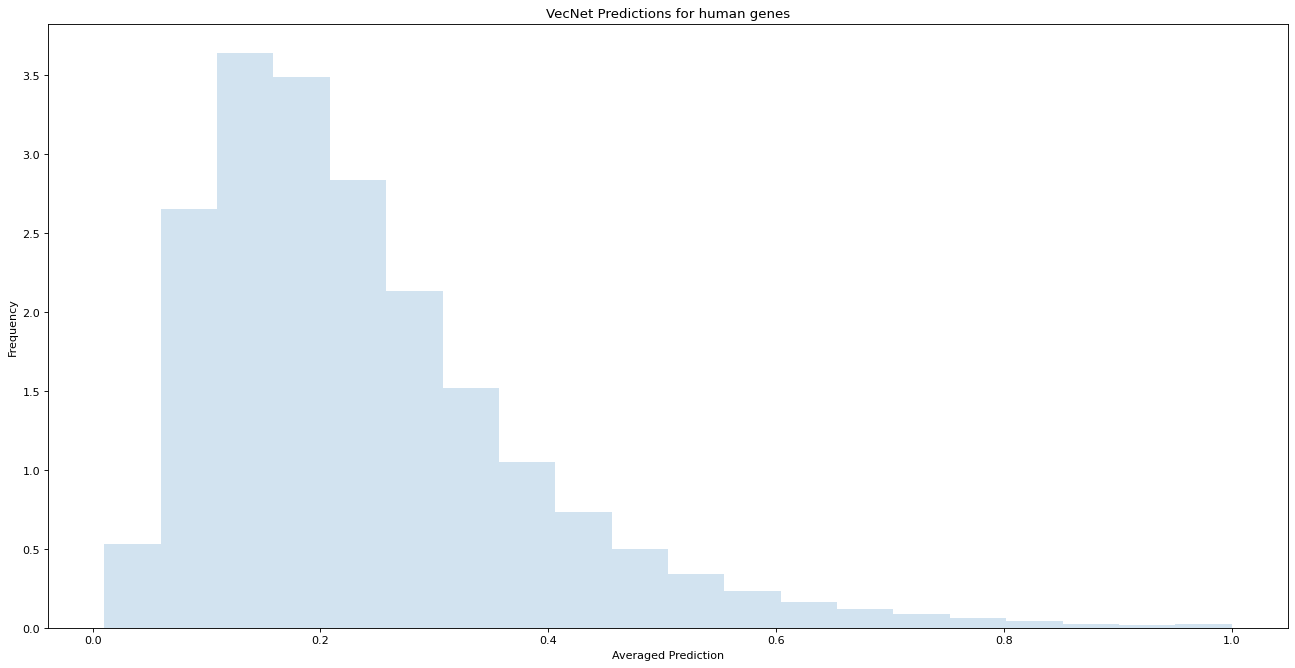

In [41]:
figure(figsize=(20, 10), dpi=80)
plt.hist(human_preidcitons_5fold_average[0]['Averaged Predictions'].tolist(),density=True,alpha=0.2,bins=20)
plt.xlabel('Averaged Prediction')
plt.ylabel('Frequency')
plt.title('VecNet Predictions for human genes')

In [42]:
human_preidcitons_5fold_average[0].to_csv('/data/sars-busters-consolidated/GitData/human_predicitons_unseen_targets.csv')

#### Predicting on CHEMBL data

In [43]:
chembl = pd.read_csv('chembl24_active_&_inactive_interactions_w_seq.csv')

In [44]:
chembl = chembl.rename(columns={'target_chemblid':'InChiKey','usmiles':'SMILE','Sequence':'target_aa_code'})

In [45]:
chembl = chembl[~chembl['target_aa_code'].isna()]

In [46]:
chembl_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                            version_number = None,
                                                                            model_paths = [],
                                                                            optimal_validation_model = None,
                                                                            test_sets = [chembl],
                                                                            get_drug_embed = True,
                                                                            get_target_embed = True,
                                                                            drug_filter_list = [],
                                                                            target_filter_list = [],
                                                                            return_dataframes = True )


Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_0/vecnet_ds2_5_fold_unseen_targets_v00_run0_07-13_23h41_epoch_14_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_1/vecnet_ds2_5_fold_unseen_targets_v00_run1_07-13_23h49_epoch_14_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_2/vecnet_ds2_5_fold_unseen_targets_v00_run2_07-13_23h57_epoch_14_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_3/vecnet_ds2_5_fold_unseen_targets_v00_run3_07-14_00h05_epoch_14_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/tar-101/Run_4/vecnet_ds2_5_fold_unseen_targets_v00_run4_07-14_00h13_epoch_14_idx_0.model
filtered_nodes_test :  (9092, 11)
Drugs :  352
Targets :  346


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (9092, 100) (9092, 300)
unseen_targets_pred :  (9092,)
list :  9092


In [47]:
true_labels = []

for index, row in chembl_5fold_average[0].iterrows():
    if row['activity_class'] == 'active':
        true_labels.append(1)
    else:
        true_labels.append(0)

In [48]:
chembl_5fold_average[0]['activity_class'].value_counts()

active      5049
inactive    4043
Name: activity_class, dtype: int64

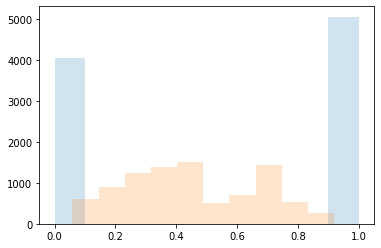

In [49]:
plt.hist(true_labels,alpha=0.2)
plt.hist(chembl_5fold_average[0]['Averaged Predictions'],alpha=0.2)
plt.show()

In [50]:
roc_auc_score(true_labels,chembl_5fold_average[0]['Averaged Predictions'].tolist())

0.49796211816260993

In [51]:
average_precision_score(true_labels,chembl_5fold_average[0]['Averaged Predictions'].tolist())

0.5598753604306482

In [52]:
confusion_matrix(true_labels,[1 if x > 0.25 else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()])

array([[ 752, 3291],
       [1011, 4038]])

In [53]:
chembl_5fold_average[0]['Y'] = true_labels
chembl_5fold_average[0]['binary_Y'] = [1 if x > 0.25 else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()]

In [54]:
chembl_fp = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 0) & (chembl_5fold_average[0].binary_Y == 1)]

In [55]:
chembl_tp = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 1) & (chembl_5fold_average[0].binary_Y == 1)]

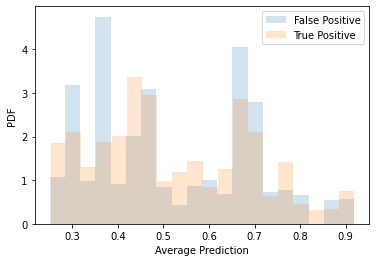

In [56]:
plt.hist(chembl_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(chembl_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.legend()
plt.xlabel('Average Prediction')
plt.ylabel('PDF')
plt.show()

In [57]:
chembl_fn = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 1) & (chembl_5fold_average[0].binary_Y == 0)]

In [58]:
chembl_tn = chembl_5fold_average[0][(chembl_5fold_average[0].Y == 0) & (chembl_5fold_average[0].binary_Y == 0)]

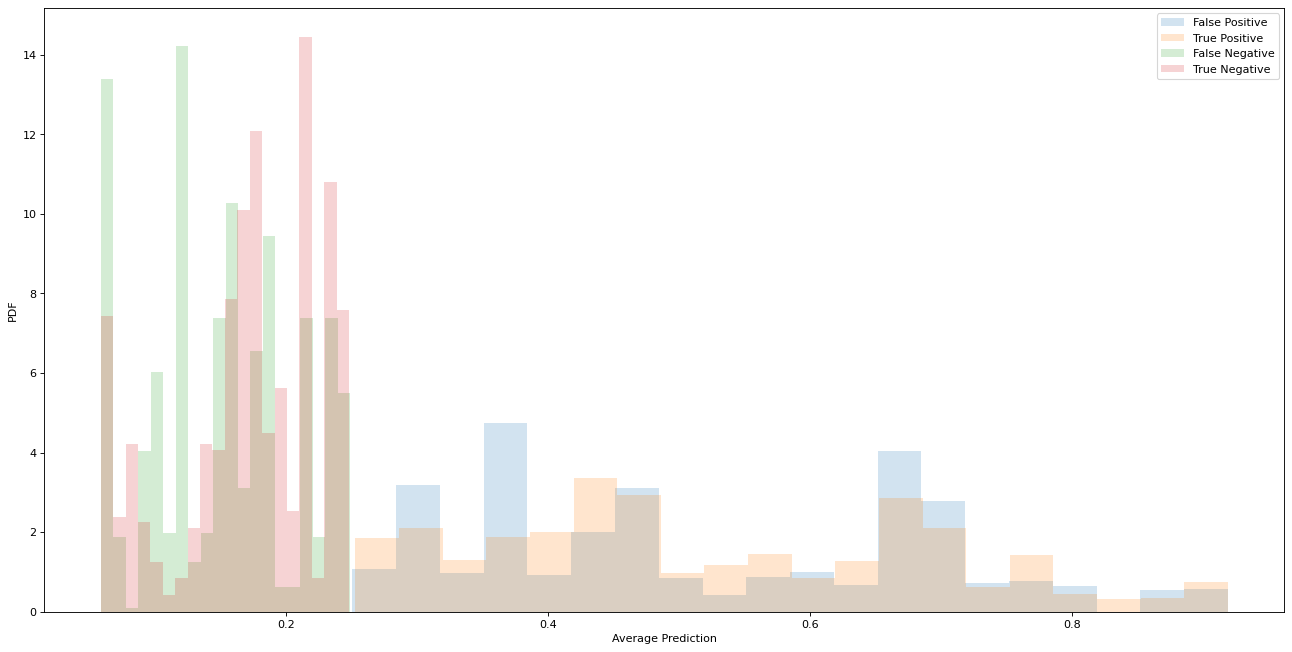

In [59]:
figure(figsize=(20, 10), dpi=80)
plt.hist(chembl_fp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Positive')
plt.hist(chembl_tp['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Positive')
plt.hist(chembl_fn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='False Negative')
plt.hist(chembl_tn['Averaged Predictions'],density=True,alpha=0.2,bins=20,label='True Negative')
plt.legend()
plt.xlabel('Average Prediction')
plt.ylabel('PDF')
plt.show()

In [60]:
from sklearn.metrics import matthews_corrcoef

for th in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(matthews_corrcoef(true_labels,[1 if x > th else 0 for x in chembl_5fold_average[0]['Averaged Predictions'].tolist()]))

-0.04428194592590596
-0.05335967852500156
0.0015716946091334483
0.04710383612586798
0.021817404819784867
-0.0224301334732143
-0.0058610827577478845
0.008443435187625628
0.011225235649297187


In [61]:
chembl_all = pd.concat([chembl_fp,chembl_fn,chembl_tp,chembl_tn])

Text(0, 0.5, 'PDF')

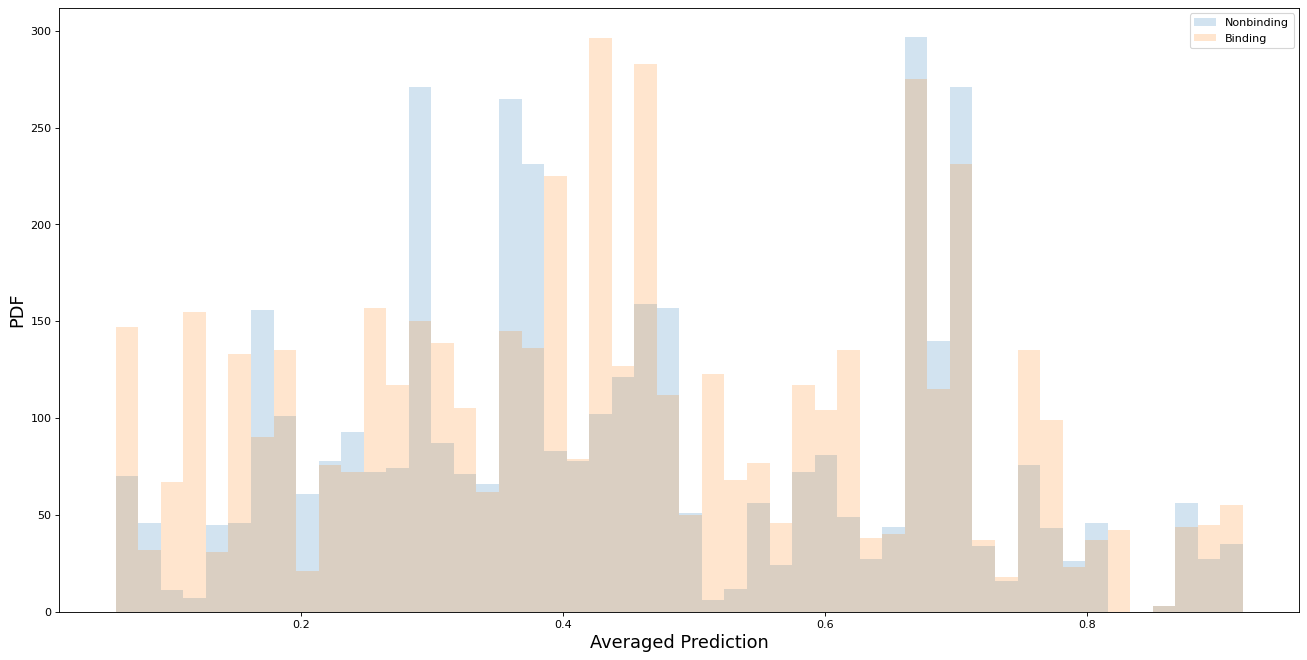

In [62]:
figure(figsize=(20, 10), dpi=80)
plt.hist(chembl_all[chembl_all['Y']==0]['Averaged Predictions'],density=False,alpha=0.2,bins=50,label='Nonbinding')
plt.hist(chembl_all[chembl_all['Y']==1]['Averaged Predictions'],density=False,alpha=0.2,bins=50,label='Binding')
plt.legend()
plt.xlabel('Averaged Prediction',fontsize=16)
plt.ylabel('PDF',fontsize=16)

In [63]:
chembl_all

InChiKey                 pref_name     target_type  \
0     CHEMBL1075051   Dihydrofolate reductase  SINGLE PROTEIN   
2     CHEMBL1075051   Dihydrofolate reductase  SINGLE PROTEIN   
4     CHEMBL1075051   Dihydrofolate reductase  SINGLE PROTEIN   
5     CHEMBL1075051   Dihydrofolate reductase  SINGLE PROTEIN   
7     CHEMBL1075051   Dihydrofolate reductase  SINGLE PROTEIN   
...             ...                       ...             ...   
8774     CHEMBL5658  Prostaglandin E synthase  SINGLE PROTEIN   
8775     CHEMBL5658  Prostaglandin E synthase  SINGLE PROTEIN   
8776     CHEMBL5658  Prostaglandin E synthase  SINGLE PROTEIN   
8814     CHEMBL5658  Prostaglandin E synthase  SINGLE PROTEIN   
8815     CHEMBL5658  Prostaglandin E synthase  SINGLE PROTEIN   

                                                  SMILE  pchembl_median  \
0     COc1cc(CSc2nc3ccc(C)cc3c(=O)n2-c2ccc(C)cc2)cc(...            5.82   
2     COc1cc(CSc2nc3ccc(C)cc3c(=O)n2-c2ccccc2)cc(OC)...            5.16   
4     COc1cc(CSc2nc3ccc(Cl)cc3c(=O)n2-c2ccc(C)cc2)cc...            5.52   
5     COc1cc(CSc2nc3ccc(Cl)cc3c(=O)n2-c2ccc(Cl)cc2)c...            5.70   
7     COc1cc(CSc2nc3ccc(Cl)cc3c(=O)n2Cc2ccccc2)cc(OC...            5.40   
...                                                 ...             ...   
8774                   COc1cc(-c2cc3ccccc3c(=O)o2)ccc1O            5.20   
8775                COc1ccc(-c2cc3cccc(O)c3c(=O)o2)cc1O            4.95   
8776                   COc1ccc(-c2cc3ccccc3c(=O)o2)cc1O            5.01   
8814                  O=c1oc(-c2ccc(O)cc2)cc2cccc(O)c12            5.15   
8815                        O=c1oc(-c2ccccc2)cc2ccccc12            5.02   

      doc_id  year  activity_threshold activity_class UniprotID  \
0     101266  2016                 6.0       inactive    P00376   
2     101266  2016                 6.0       inactive    P00376   
4     101266  2016                 6.0       inactive    P00376   
5     101266  2016                 6.0       inactive    P00376   
7     101266  2016                 6.0       inactive    P00376   
...      ...   ...                 ...            ...       ...   
8774  101955  2016                 6.0       inactive    O14684   
8775  101955  2016                 6.0       inactive    O14684   
8776  101955  2016                 6.0       inactive    O14684   
8814  101955  2016                 6.0       inactive    O14684   
8815  101955  2016                 6.0       inactive    O14684   

                                         target_aa_code  Averaged Predictions  \
0     MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...              0.358064   
2     MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...              0.358064   
4     MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...              0.358064   
5     MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...              0.358064   
7     MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFQYFQRMTTVSSVEG...              0.358064   
...                                                 ...                   ...   
8774  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...              0.097141   
8775  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...              0.097141   
8776  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...              0.097141   
8814  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...              0.097141   
8815  MPAHSLVMSSPALPAFLLCSTLLVIKMYVVAIITGQVRLRKKAFAN...              0.097141   

      Y  binary_Y  
0     0         1  
2     0         1  
4     0         1  
5     0         1  
7     0         1  
...  ..       ...  
8774  0         0  
8775  0         0  
8776  0         0  
8814  0         0  
8815  0         0  

[9092 rows x 14 columns]

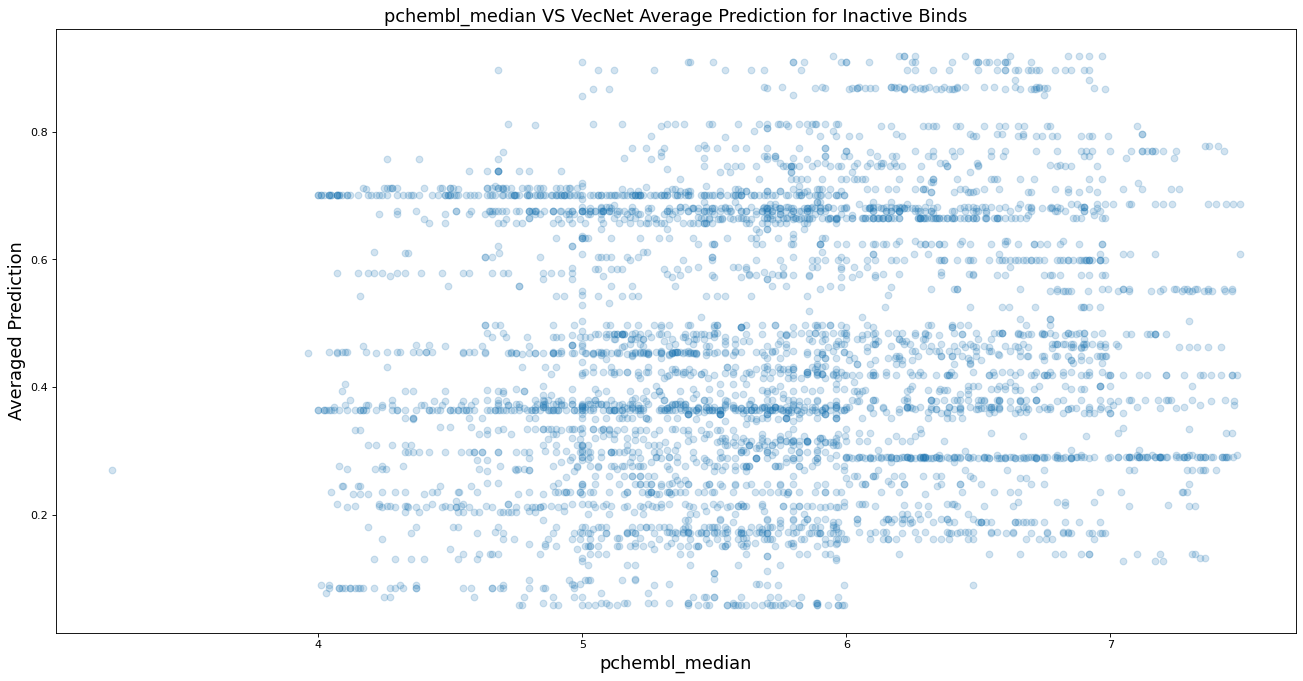

In [64]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for Inactive Binds',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==0]['pchembl_median'],chembl_all[chembl_all['Y']==0]['Averaged Predictions'],alpha=0.2)
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.show()

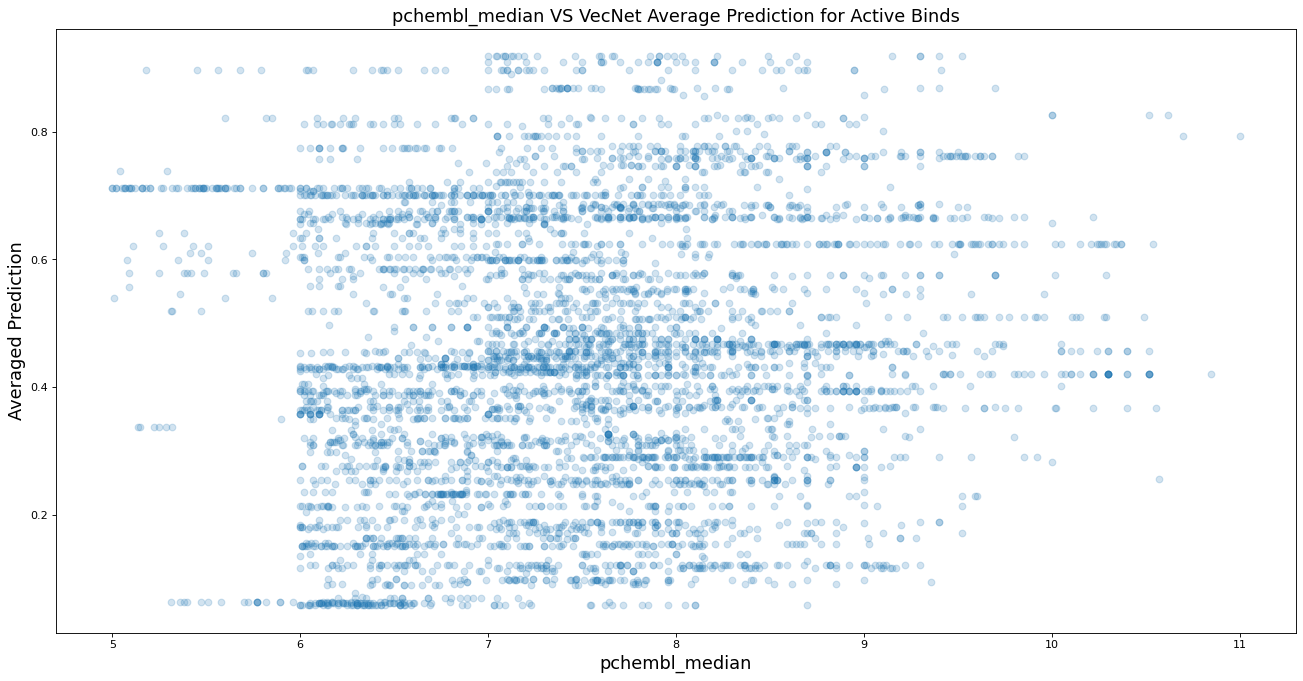

In [65]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for Active Binds',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==1]['pchembl_median'],chembl_all[chembl_all['Y']==1]['Averaged Predictions'],alpha=0.2)
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.show()

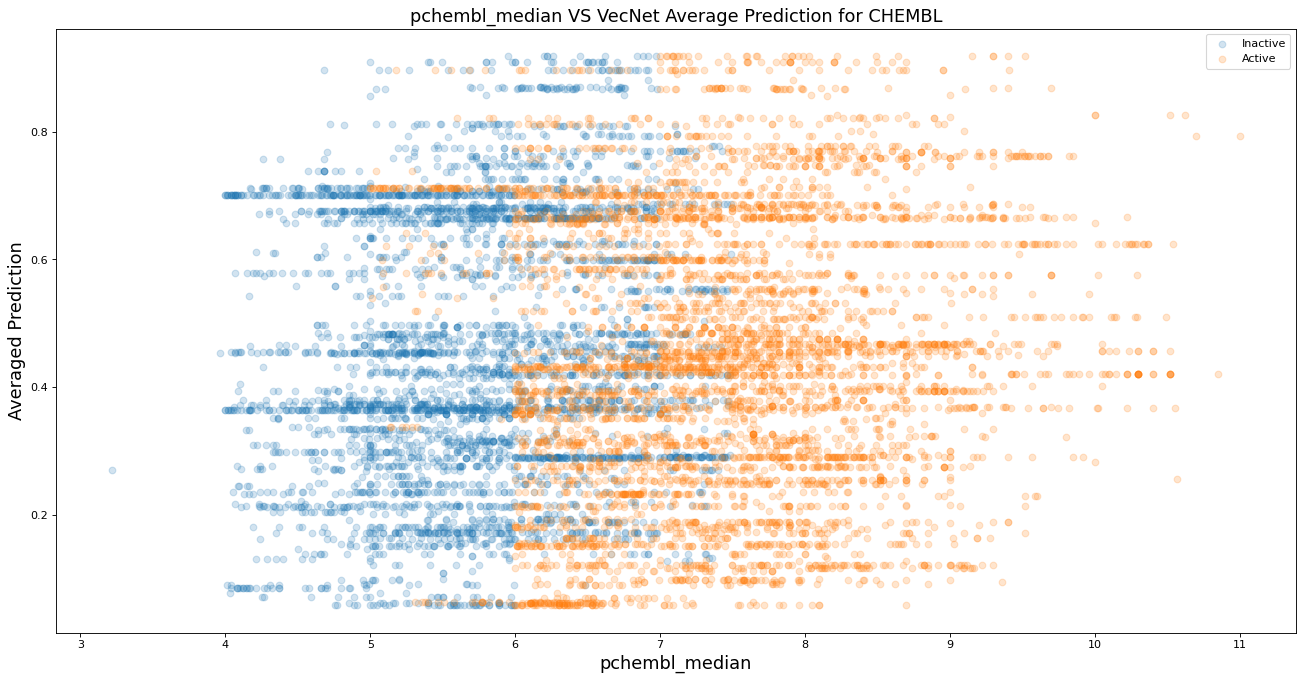

In [66]:
figure(figsize=(20, 10), dpi=80)
plt.title('pchembl_median VS VecNet Average Prediction for CHEMBL',fontsize=16)
plt.scatter(chembl_all[chembl_all['Y']==0]['pchembl_median'],chembl_all[chembl_all['Y']==0]['Averaged Predictions'],alpha=0.2,label='Inactive')
plt.scatter(chembl_all[chembl_all['Y']==1]['pchembl_median'],chembl_all[chembl_all['Y']==1]['Averaged Predictions'],alpha=0.2,label='Active')
plt.xlabel('pchembl_median',fontsize=16)
plt.ylabel('Averaged Prediction',fontsize=16)
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.show()